In [44]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

## **ALGORITHM**

In [45]:
from google.colab import drive
drive.mount('/content/drive')

for f in os.listdir('/content/drive/MyDrive/Cs310_Project'):
    print(f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cs310 Presentation.gslides
Indian_Traffic_Sign_Data
Banglore_traffic_Dataset.csv
hotosm_ind_roads_lines_geojson.geojson
Bangalore_roadnetwork_dataset
hotosm_ind_roads_lines_gpkg.gpkg
Indian_Signs_Kaggle.ipynb
CS 310 Final Prestation.gslides
manik-final-Bangalore.ipynb
Bangalore_Traffic_Analysis_and_Prediction.ipynb
Traffic_Signs.ipynb


In [3]:
!pip install pyogrio --quiet


<Axes: >

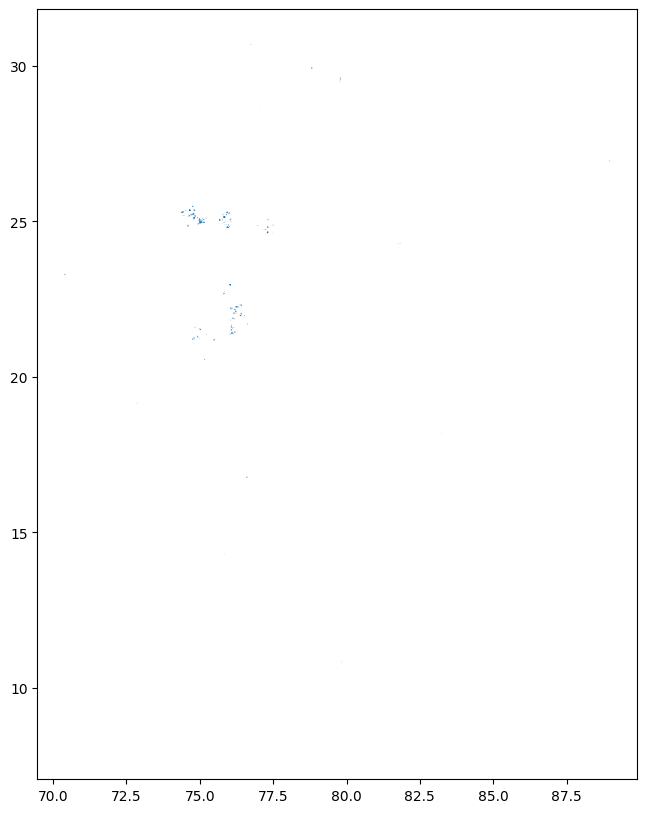

In [46]:
import geopandas as gpd

path = '/content/drive/MyDrive/Cs310_Project/hotosm_ind_roads_lines_geojson.geojson'
roads_sample = gpd.read_file(path, engine='pyogrio', max_features=1000)

# Preview
roads_sample.plot(figsize=(10, 10), linewidth=0.5)


In [47]:
from shapely.geometry import box

bbox = box(77.4, 12.8, 77.8, 13.2)  # Approx Bangalore extent


In [48]:
from shapely.geometry import box

# Path to the .gpkg file
gpkg_path = '/content/drive/MyDrive/Cs310_Project/hotosm_ind_roads_lines_gpkg.gpkg'

# Define bounding box for Bangalore (minx, miny, maxx, maxy)
bangalore_bbox = box(77.4, 12.8, 77.8, 13.2)

# Load only features within the bounding box
bangalore_roads = gpd.read_file(gpkg_path, bbox=bangalore_bbox, engine='pyogrio')

# Check result
print("Loaded road segments:", len(bangalore_roads))


Loaded road segments: 194802


In [49]:
import networkx as nx

# Initialize empty graph
G = nx.Graph()

# Iterate over each road segment
for idx, row in bangalore_roads.iterrows():
    geom = row.geometry

    # Handle LineString and MultiLineString geometries
    if geom.geom_type == 'LineString':
        coords = list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        coords = list(geom[0].coords)
    else:
        continue

    # Add edges between consecutive points
    for i in range(len(coords) - 1):
        pt1, pt2 = coords[i], coords[i + 1]
        dist = ((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2) ** 0.5
        G.add_edge(pt1, pt2, weight=dist)


In [50]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))


Number of nodes: 725053
Number of edges: 787763


In [53]:
import random

# Choose two random points
nodes = list(G.nodes)
start = random.choice(nodes)
end = random.choice(nodes)

# Compute shortest path
path = nx.shortest_path(G, source=start, target=end, weight='weight')
print("Shortest path found with", len(path), "nodes.")


Shortest path found with 898 nodes.


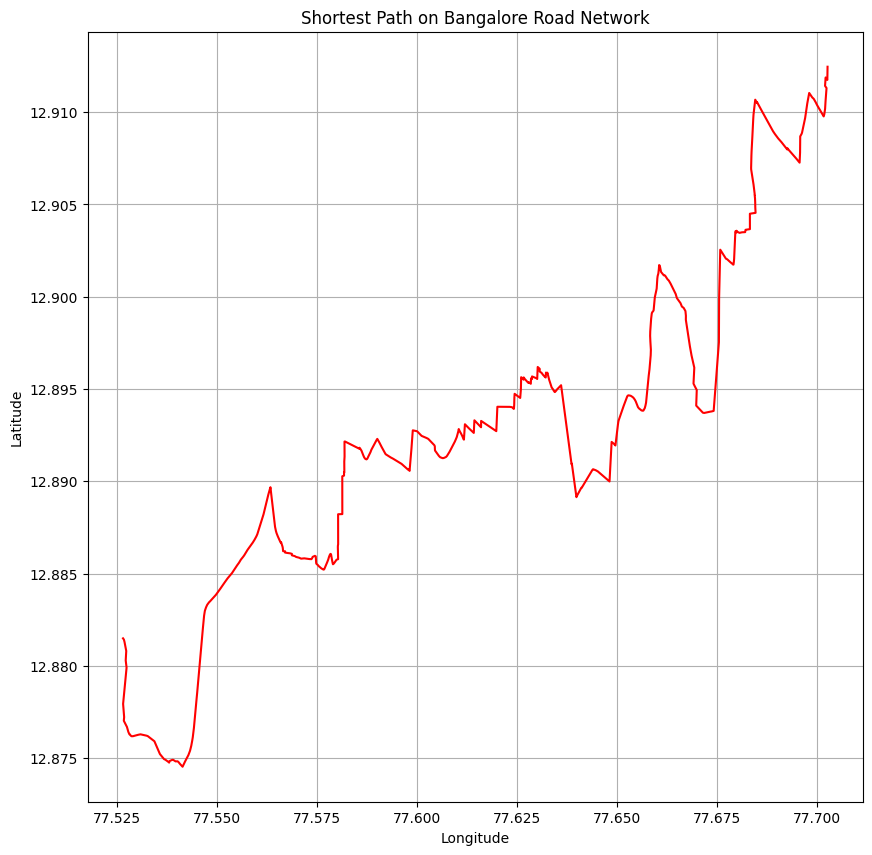

In [54]:
x, y = zip(*path)
plt.figure(figsize=(10, 10))
plt.plot(x, y, color='red')
plt.title("Shortest Path on Bangalore Road Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [13]:
!pip install folium --quiet


In [55]:
import folium
from IPython.display import Image

center_lat = 13.0
center_lon = 77.6

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Plot road network (gray)
for _, row in bangalore_roads.iterrows():
    geom = row.geometry
    if geom.geom_type == 'LineString':
        coords = [(lat, lon) for lon, lat in geom.coords]
        folium.PolyLine(coords, color='gray', weight=1, opacity=0.3).add_to(m)
    elif geom.geom_type == 'MultiLineString':
        for line in geom:
            coords = [(lat, lon) for lon, lat in line.coords]
            folium.PolyLine(coords, color='gray', weight=1, opacity=0.3).add_to(m)

# Add path
path_coords = [(lat, lon) for lon, lat in path]
folium.PolyLine(path_coords, color='red', weight=3, opacity=1).add_to(m)

# Add start and end markers
folium.Marker(path_coords[0], popup="Start", icon=folium.Icon(color='green')).add_to(m)
folium.Marker(path_coords[-1], popup="End", icon=folium.Icon(color='red')).add_to(m)

# Save as HTML
m.save("/content/bangalore_path.html")

In [66]:
from google.colab import files
files.download("/content/bangalore_path.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

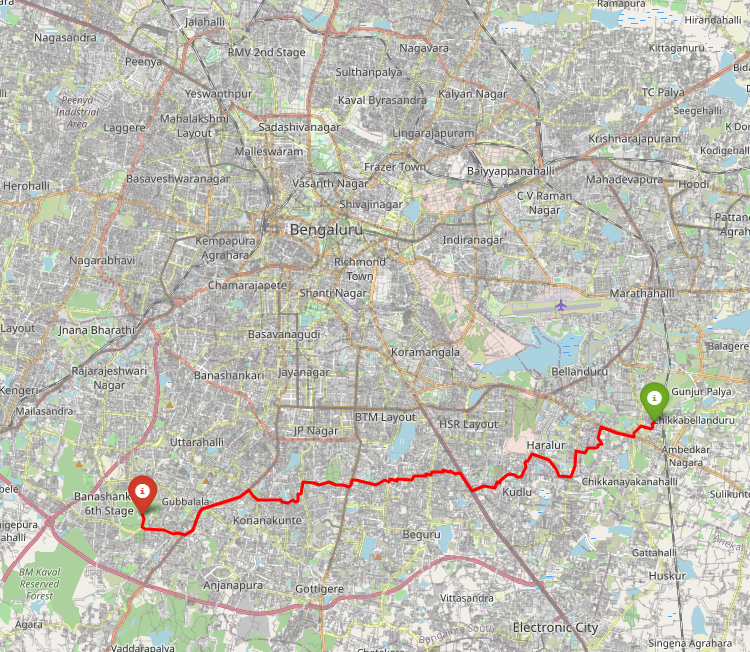

In [67]:
from IPython.display import Image

Image("/content/drive/MyDrive/unweighted.png")


In [56]:
import pandas as pd

traffic = pd.read_csv('/content/drive/MyDrive/Cs310_Project/Banglore_traffic_Dataset.csv')
traffic.head()

,Date,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity
0,2022-01-01,Indiranagar,100 Feet Road,50590,50.230299,1.500000,100.000000,100.000000,0,151.180,70.632330,84.044600,85.403629,111,Clear,No
1,2022-01-01,Indiranagar,CMH Road,30825,29.377125,1.500000,100.000000,100.000000,1,111.650,41.924899,91.407038,59.983689,100,Clear,No
2,2022-01-01,Whitefield,Marathahalli Bridge,7399,54.474398,1.039069,28.347994,36.396525,0,64.798,44.662384,61.375541,95.466020,189,Clear,No
3,2022-01-01,Koramangala,Sony World Junction,60874,43.817610,1.500000,100.000000,100.000000,1,171.748,32.773123,75.547092,63.567452,111,Clear,No
4,2022-01-01,Koramangala,Sarjapur Road,57292,41.116763,1.500000,100.000000,100.000000,3,164.584,35.092601,64.634762,93.155171,104,Clear,No


In [57]:
bangalore_roads.columns  # check if 'highway' is present


Index(['name', 'name:en', 'highway', 'surface', 'smoothness', 'width', 'lanes',
       'oneway', 'bridge', 'layer', 'source', 'name:hi', 'name:ta', 'osm_id',
       'osm_type', 'geometry'],
      dtype='object')

In [58]:
bangalore_roads['highway'].value_counts()


,count
highway,
residential,131093
service,31255
footway,9369
tertiary,5517
track,3096
secondary,2688
construction,2099
primary,2013
living_street,1918


In [59]:
highway_speed_map = {
    'motorway': 100,
    'motorway_link': 80,
    'trunk': 80,
    'trunk_link': 70,
    'primary': 60,
    'primary_link': 50,
    'secondary': 50,
    'secondary_link': 40,
    'tertiary': 40,
    'tertiary_link': 35,
    'residential': 30,
    'living_street': 20,
    'service': 25,
    'unclassified': 25,
    'road': 30,
    'footway': 5,
    'pedestrian': 5,
    'steps': 2,
    'cycleway': 15,
    'track': 20,
    'path': 10,
    'bridleway': 10,
    'busway': 40,
    'raceway': 120,
    'platform': 0,
    'bus_stop': 0,
    'corridor': 0,
    'proposed': 0  # not built yet
}


In [60]:
import networkx as nx

# Your existing speed map
highway_speed_map = {
    'motorway': 100, 'motorway_link': 80,
    'trunk': 80, 'trunk_link': 70,
    'primary': 60, 'primary_link': 50,
    'secondary': 50, 'secondary_link': 40,
    'tertiary': 40, 'tertiary_link': 35,
    'residential': 30, 'living_street': 20,
    'service': 25, 'unclassified': 25,
    'road': 30, 'footway': 5, 'pedestrian': 5,
    'steps': 2, 'cycleway': 15, 'track': 20,
    'path': 10, 'bridleway': 10, 'busway': 40
}

# Build the graph
G = nx.Graph()

for idx, row in bangalore_roads.iterrows():
    geom = row.geometry
    road_type = row.get('highway')
    speed = highway_speed_map.get(road_type, 40)  # default to 40 km/h

    # Skip if geometry is missing or speed is zero (like 'platform')
    if geom is None or speed == 0:
        continue

    # Extract coordinates
    if geom.geom_type == 'LineString':
        coords = list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        coords = list(geom[0].coords)
    else:
        continue

    # Add edges with travel time as weight
    for i in range(len(coords) - 1):
        pt1, pt2 = coords[i], coords[i + 1]
        dist_deg = ((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)**0.5
        dist_km = dist_deg * 111  # Approximate conversion to km
        travel_time_min = dist_km / (speed / 60)  # min = km / (km/h * 60)

        G.add_edge(pt1, pt2, weight=travel_time_min)


In [61]:
# Save start and end to reuse later
saved_start = start
saved_end = end
# Fastest path using speed-limit-based weights
fastest_path_speed = nx.shortest_path(G, source=saved_start, target=saved_end, weight='weight')
print("Fastest path with speed limits has", len(fastest_path_speed), "nodes.")


Fastest path with speed limits has 752 nodes.


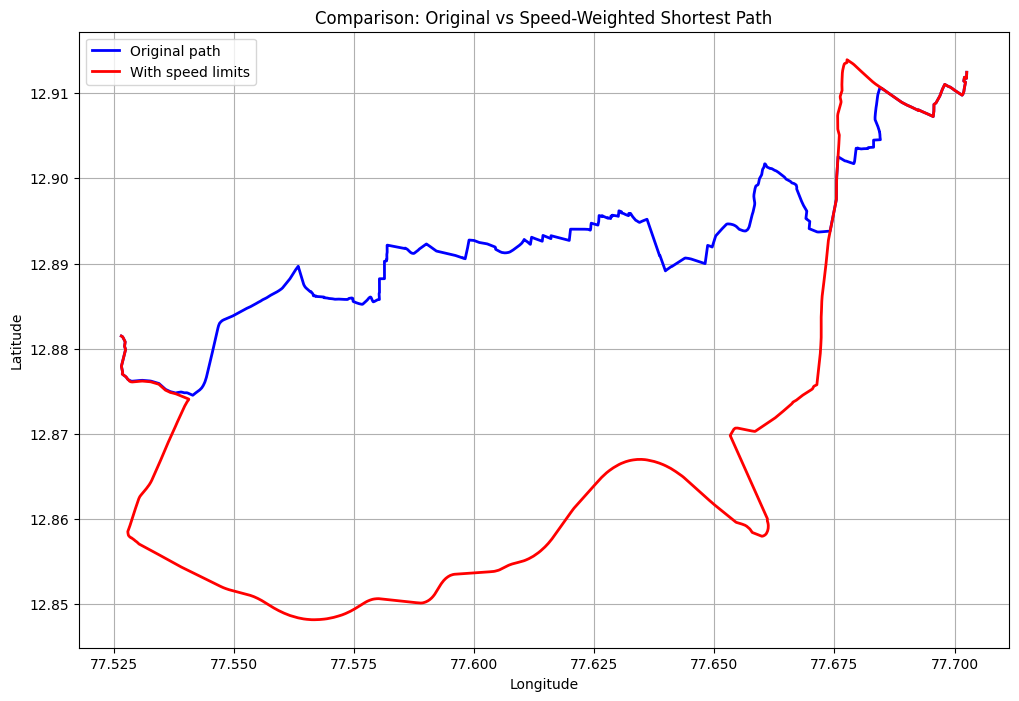

In [62]:
# Plot both on same map (matplotlib)
# Old one (random weight or distance-based)
old_lons, old_lats = zip(*path)
# New one (speed-based)
new_lons, new_lats = zip(*fastest_path_speed)

plt.figure(figsize=(12, 8))
plt.plot(old_lons, old_lats, 'blue', linewidth=2, label="Original path")
plt.plot(new_lons, new_lats, 'red', linewidth=2, label="With speed limits")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Comparison: Original vs Speed-Weighted Shortest Path")
plt.grid(True)
plt.show()


In [63]:
import folium

# Initialize the map centered at the start point
m = folium.Map(location=[saved_start[1], saved_start[0]], zoom_start=13)

# Plot original path (distance-based)
folium.PolyLine([(lat, lon) for lon, lat in path], color='blue', weight=3, tooltip="Original path").add_to(m)

# Plot new path (speed-limit-weighted)
folium.PolyLine([(lat, lon) for lon, lat in fastest_path_speed], color='red', weight=3, tooltip="With speed limits").add_to(m)

# Add start and end markers
folium.Marker([saved_start[1], saved_start[0]], tooltip="Start", icon=folium.Icon(color='green')).add_to(m)
folium.Marker([saved_end[1], saved_end[0]], tooltip="End", icon=folium.Icon(color='red')).add_to(m)


m.save("/content/bangalore_path_weighted.html")

In [68]:
from google.colab import files
files.download("/content/bangalore_path_weighted.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

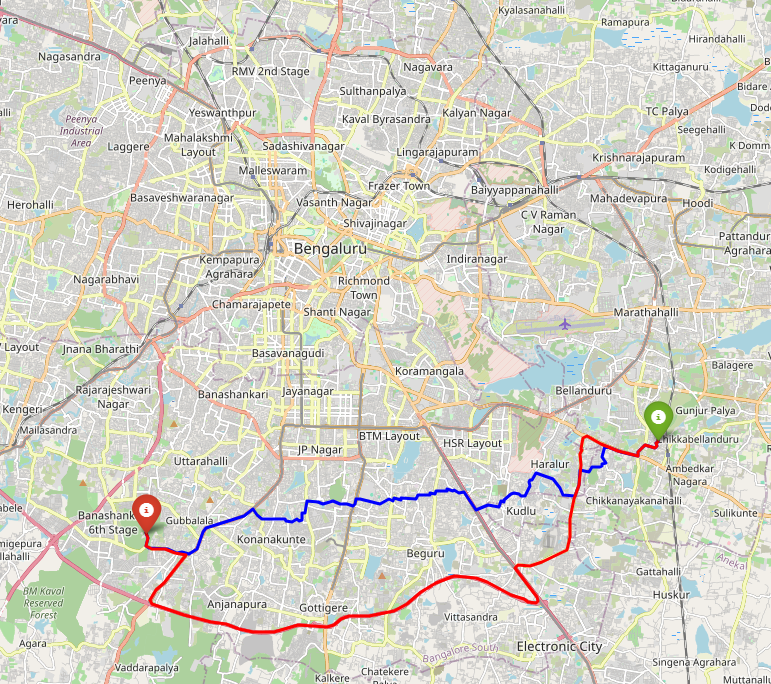

In [69]:
from IPython.display import Image

Image("/content/drive/MyDrive/weighted.png")


In [64]:
import time
import networkx as nx

# Define Euclidean distance heuristic for A*
def euclidean_heuristic(u, v):
    return ((u[0] - v[0]) ** 2 + (u[1] - v[1]) ** 2) ** 0.5

# Use same start and end from before
print("Start:", start)
print("End:", end)

# Run A* shortest path algorithm
start_time = time.time()
astar_path = nx.astar_path(G, source=start, target=end, weight='weight', heuristic=euclidean_heuristic)
time_astar = time.time() - start_time

print("A* path found with", len(astar_path), "nodes.")
print(f"A* runtime: {time_astar:.4f} seconds")


Start: (77.7025497, 12.9124627)
End: (77.5266043, 12.8814863)
A* path found with 752 nodes.
A* runtime: 1.8895 seconds


In [65]:
start_time = time.time()
dijkstra_path = nx.shortest_path(G, source=start, target=end, weight='weight')
time_dijkstra = time.time() - start_time

print("Dijkstra path found with", len(dijkstra_path), "nodes.")
print(f"Dijkstra runtime: {time_dijkstra:.4f} seconds")


Dijkstra path found with 752 nodes.
Dijkstra runtime: 2.2371 seconds


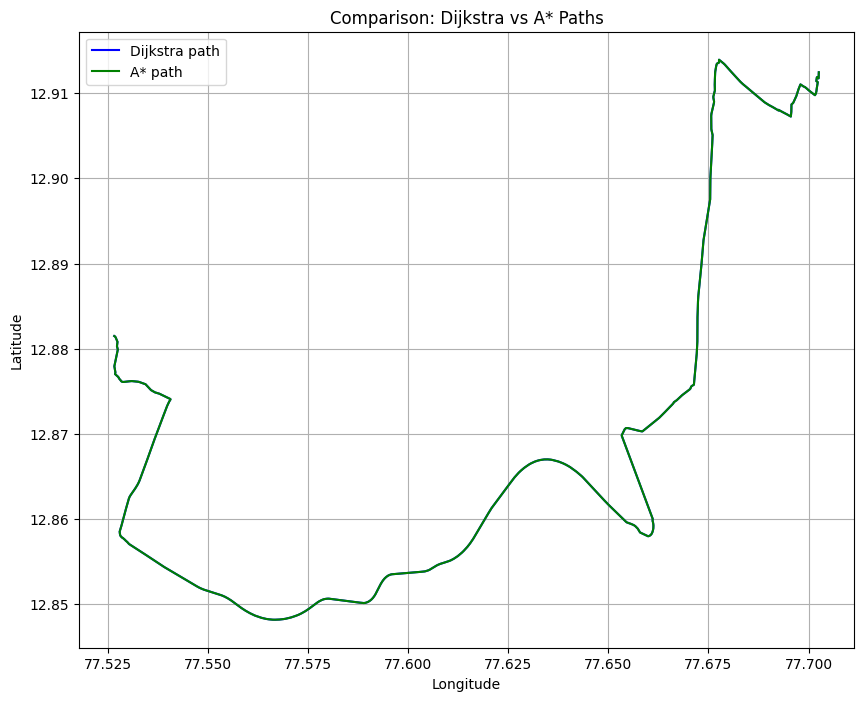

In [70]:
# Extract coordinates
astar_coords = list(astar_path)
dijkstra_coords = list(dijkstra_path)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(*zip(*dijkstra_coords), color='blue', label='Dijkstra path')
plt.plot(*zip(*astar_coords), color='green', label='A* path')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparison: Dijkstra vs A* Paths")
plt.legend()
plt.grid()
plt.show()


In [78]:
import random
from itertools import combinations

def euclidean_heuristic(u, v):
    return ((u[0] - v[0])**2 + (u[1] - v[1])**2)**0.5

all_nodes = list(G.nodes)
selected_pairs = []
checked = set()
attempts = 0

while len(selected_pairs) < 10 and attempts < 10000:
    start, end = random.sample(all_nodes, 2)
    if (start, end) in checked or not nx.has_path(G, start, end):
        attempts += 1
        continue
    checked.add((start, end))

    dist = euclidean_heuristic(start, end)

    # Optional: filter out too short paths (like < 500m)
    if dist < 0.02:  # ~2km
        continue

    selected_pairs.append((start, end, dist))
    print(f"✓ Pair {len(selected_pairs)} added | Distance: {dist:.4f}")
    attempts += 1

selected_pairs.sort(key=lambda x: x[2], reverse=True)


✓ Pair 1 added | Distance: 0.2470
✓ Pair 2 added | Distance: 0.1470
✓ Pair 3 added | Distance: 0.1478
✓ Pair 4 added | Distance: 0.1886
✓ Pair 5 added | Distance: 0.2448
✓ Pair 6 added | Distance: 0.0976
✓ Pair 7 added | Distance: 0.0510
✓ Pair 8 added | Distance: 0.0844
✓ Pair 9 added | Distance: 0.2468
✓ Pair 10 added | Distance: 0.0799


In [79]:
import random
results = []

for start, end, dist in selected_pairs:
    t0 = time.time()
    path_d = nx.shortest_path(G, source=start, target=end, weight='weight')
    t_d = time.time() - t0

    t0 = time.time()
    path_a = nx.astar_path(G, source=start, target=end, weight='weight', heuristic=euclidean_heuristic)
    t_a = time.time() - t0

    results.append({
        "Path Length": len(path_d),
        "Dijkstra Time (s)": t_d,
        "A* Time (s)": t_a
    })

    print(f"Path Length: {len(path_d)} | Dijkstra: {t_d:.4f}s | A*: {t_a:.4f}s")

df_benchmark = pd.DataFrame(results)
df_benchmark = df_benchmark.sort_values("Path Length")


Path Length: 1082 | Dijkstra: 12.8722s | A*: 5.2945s
Path Length: 1129 | Dijkstra: 10.4827s | A*: 5.0982s
Path Length: 499 | Dijkstra: 1.0337s | A*: 2.3221s
Path Length: 633 | Dijkstra: 1.7992s | A*: 2.2702s
Path Length: 859 | Dijkstra: 4.2094s | A*: 2.4294s
Path Length: 682 | Dijkstra: 2.3212s | A*: 2.2820s
Path Length: 402 | Dijkstra: 1.2120s | A*: 0.8876s
Path Length: 448 | Dijkstra: 1.1065s | A*: 1.5163s
Path Length: 472 | Dijkstra: 0.3880s | A*: 0.3669s
Path Length: 198 | Dijkstra: 0.1182s | A*: 0.2407s


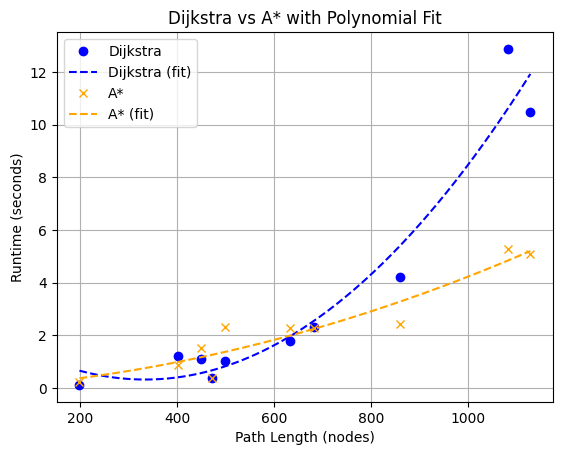

In [80]:
# Sort DataFrame just in case
df_benchmark = df_benchmark.sort_values("Path Length")

x = df_benchmark["Path Length"].values
y_dijkstra = df_benchmark["Dijkstra Time (s)"].values
y_astar = df_benchmark["A* Time (s)"].values

# Polynomial fits (degree 2)
poly_d = np.poly1d(np.polyfit(x, y_dijkstra, deg=2))
poly_a = np.poly1d(np.polyfit(x, y_astar, deg=2))

x_fit = np.linspace(x.min(), x.max(), 200)

plt.plot(x, y_dijkstra, 'o', label="Dijkstra", color='blue')
plt.plot(x_fit, poly_d(x_fit), '--', color='blue', label="Dijkstra (fit)")

plt.plot(x, y_astar, 'x', label="A*", color='orange')
plt.plot(x_fit, poly_a(x_fit), '--', color='orange', label="A* (fit)")

plt.xlabel("Path Length (nodes)")
plt.ylabel("Runtime (seconds)")
plt.title("Dijkstra vs A* with Polynomial Fit")
plt.legend()
plt.grid(True)
plt.show()


In [81]:
(df_benchmark["Dijkstra Time (s)"] / df_benchmark["A* Time (s)"]).mean()


np.float64(1.2118807644606364)

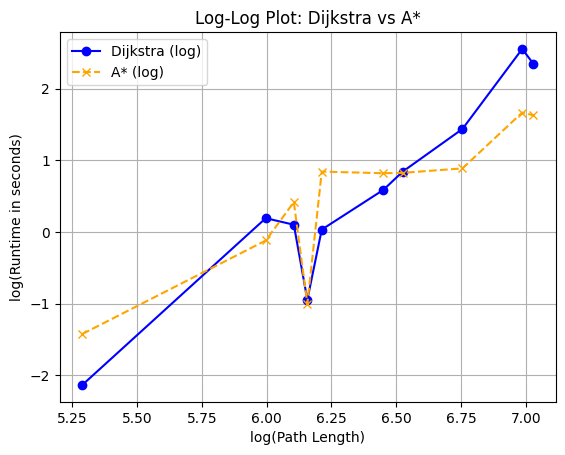

In [82]:
x_log = np.log(df_benchmark["Path Length"])
y_d_log = np.log(df_benchmark["Dijkstra Time (s)"])
y_a_log = np.log(df_benchmark["A* Time (s)"])

plt.plot(x_log, y_d_log, 'o-', label="Dijkstra (log)", color='blue')
plt.plot(x_log, y_a_log, 'x--', label="A* (log)", color='orange')

plt.xlabel("log(Path Length)")
plt.ylabel("log(Runtime in seconds)")
plt.title("Log-Log Plot: Dijkstra vs A*")
plt.legend()
plt.grid(True)
plt.show()


In [84]:
from scipy.stats import linregress


slope_d, intercept_d, *_ = linregress(x_log, y_d_log)
slope_a, intercept_a, *_ = linregress(x_log, y_a_log)

print(f"Dijkstra slope ≈ {slope_d:.2f}")
print(f"A* slope ≈ {slope_a:.2f}")


Dijkstra slope ≈ 2.61
A* slope ≈ 1.75
